In [1]:
import sys
sys.path.append('/../QmeQ/qmeq/')
#sys.path.append('../qmeq/')
import qmeq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#--SETUP: ---------------------------------------------------------------------------------
epsilons = np.linspace(-100, 100, 10)
omega = 0.105
u_intra = 500
u_inter = 300
V_B = 50
mu_L = -V_B/2       
mu_R = V_B/2        

gammaL = 0.1
gammaR = gammaL
tL = np.sqrt(gammaL/np.pi/2)
tR = np.sqrt(gammaR/np.pi/2)
T_L = 10
T_R = 1
n = 4
nleads = 4

U = {(0,1,1,0):u_intra, (2,3,3,2):u_intra, (0,2,2,0):u_inter, (0,3,3,0):u_inter, (1,2,2,1):u_inter, (1,3,3,1):u_inter } 
mulst = {0:mu_L, 1:mu_L, 2:mu_R, 3:mu_R}
tlst = {0:T_L, 1:T_L, 2:T_R, 3:T_R}

if T_L < T_R:
    raise SystemExit("Not my convention! (T_L < T_R) so cell was shut down")
elif T_L > T_R:
    T_COLD = T_R
    T_HOT = T_L
elif T_L == T_R:
    raise SystemExit("Not a heat engine (T_L = T_R) so cell was shut down")

In [3]:
#Från series till parallel!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#series: omega = 1, tL* = 0:   lamda = 0
#parallel: omega = 0, tL* = 1:  lamda = 1
#lmda : 0 -> 1
lamdas = np.linspace(0,1,12)
I = []
I_var = []
J_QH = []
heat_engine_epsilons = []

#system = qmeq.Builder(nsingle=n, coulomb=U, nleads=nleads,
#                        mulst=mulst, tlst=tlst, dband=1e4, countingleads=[0,1], kerntype='pyLindblad')


for l_idx, lmda in enumerate(lamdas):
    QH_s = []
    I_s = []
    I_vars = []
    heat_epses = []
    for e_idx, eps in enumerate(epsilons):
        system = qmeq.Builder(nsingle=n, hsingle={(0,0):eps, (1,1):eps, (2,2):eps+1, (3,3):eps+1, (0,2):(1-lmda)*omega, (1,3):(1-lmda)*omega}, coulomb=U, nleads=nleads,
                        mulst=mulst, tlst=tlst, tleads={(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR, (0,2):lmda*tL, (1,3):lmda*tL, (2,0):lmda*tR, (3,1):lmda*tR},
                        dband=1e4, countingleads=[0,1], kerntype='pyLindblad')
        #system.change(hsingle={(0,0):eps, (1,1):eps, (2,2):eps+1, (3,3):eps+1, (0,2):(1-lmda)*omega, (1,3):(1-lmda)*omega})
        #system.change(tleads={(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR, (0,2):lmda*tL, (1,3):lmda*tL, (2,0):lmda*tR, (3,1):lmda*tR})
        system.solve()
        if system.current_noise[1] < 0:
            print(system.current_noise[1], lmda, eps)
        j_qh = system.heat_current[0]+system.heat_current[1]
        i = system.current_noise[0]
        if j_qh > 0 and i > 0:
            QH_s.append(j_qh)
            I_s.append(i)
            I_vars.append(system.current_noise[1])
            heat_epses.append(eps)
        #print(system.heat_current, lmda, eps)

    J_QH.append(QH_s)
    I.append(I_s)
    I_var.append(I_vars)
    heat_engine_epsilons.append(heat_epses)
    
'''
print(len(J_QH))
print(len(J_QH[0]))
print(len(I))
print(len(I[1]))
print(len(I_var))
print(len(I_var[2]))
'''
print(heat_engine_epsilons)


[[np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.77777777777777), np.float64(100.0)], [np.float64(33.333333333333314), np.float64(55.55555555555554), np.float64(77.7

In [4]:
#Calculations of P, efficiency, sigma and TUR
is_equal = all(row == heat_engine_epsilons[0] for row in heat_engine_epsilons)
if not is_equal:
    raise SystemExit("~~~ Not the same heat engine epsilons for all lambdas! This must be handled ~~~")

J_QH = np.array(J_QH)
I = np.array(I)
I_var = np.array(I_var)

print(I)

P = I*V_B
#print(P)
eff_carnot = 1-(T_COLD/T_HOT)
#print(eff_carnot)
eff = P/J_QH
#print(eff)
sigma = P*(1/T_COLD)*(eff_carnot-eff)/eff
TUR = I_var*sigma/(I**2)


[[1.08958614e-05 1.26356393e-06 1.37023707e-07 1.48500903e-08]
 [1.66708322e-05 1.88309106e-06 2.04235916e-07 2.21346294e-08]
 [3.84655352e-05 4.37410547e-06 4.74392711e-07 5.14134609e-08]
 [7.46815495e-05 8.55247868e-06 9.27525447e-07 1.00522446e-07]
 [1.22446122e-04 1.40833318e-05 1.52731519e-06 1.65525436e-07]
 [1.78185232e-04 2.05486796e-05 2.22843089e-06 2.41509585e-07]
 [2.38294536e-04 2.75268499e-05 2.98514434e-06 3.23519036e-07]
 [2.99659967e-04 3.46540613e-05 3.75800860e-06 4.07278714e-07]
 [3.59913086e-04 4.16544973e-05 4.51711851e-06 4.89547671e-07]
 [4.17451562e-04 4.83425419e-05 5.24235133e-06 5.68145155e-07]
 [4.71322908e-04 5.46088707e-05 5.92185714e-06 6.41786983e-07]
 [5.21063380e-04 6.04013140e-05 6.54998281e-06 7.09860538e-07]]


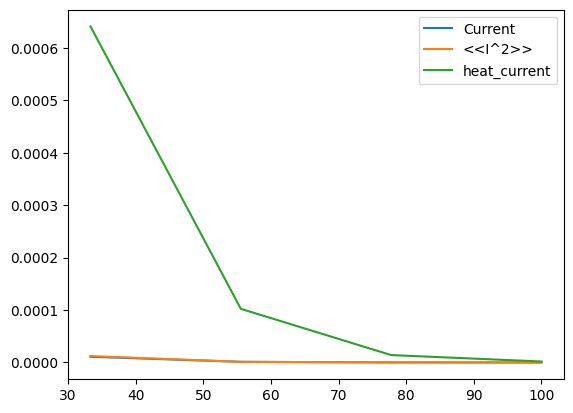

In [5]:
heat_engine_epsilons = np.array(heat_engine_epsilons)

plt.plot(heat_engine_epsilons[0], I[0], label='Current')
plt.plot(heat_engine_epsilons[0], I_var[0], label='<<I^2>>')
plt.plot(heat_engine_epsilons[0], J_QH[0], label='heat_current')
plt.legend()
plt.show()

1835.5593192276372
1835.5593192276372
81512.18095380068
81512.18095380068
31237.910771990006
31237.910771990006


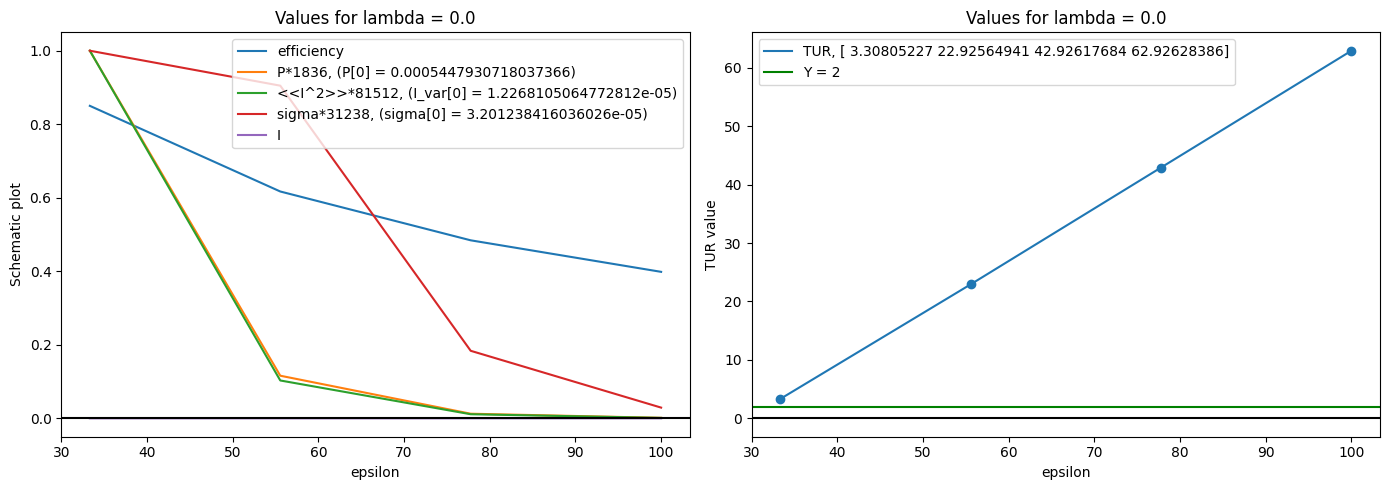

1199.7001554084607
1199.7001554084607
56155.70477539336
56155.70477539336
17602.16637766316
17602.16637766316


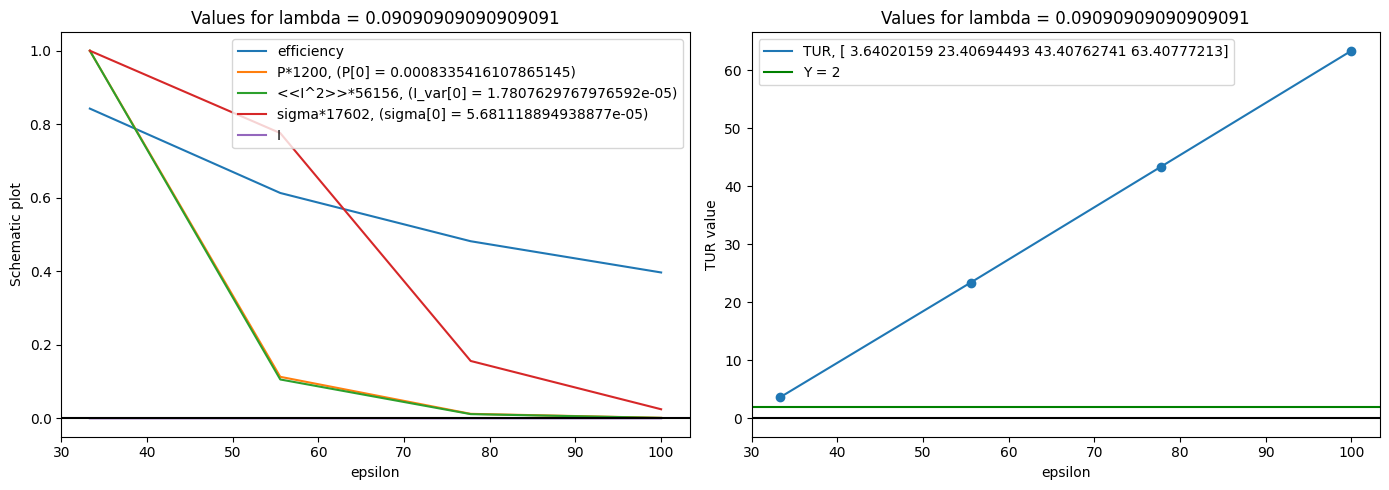

519.9459696723334
519.9459696723334
24023.98724218075
24023.98724218075
7902.8129056688185
7902.8129056688185


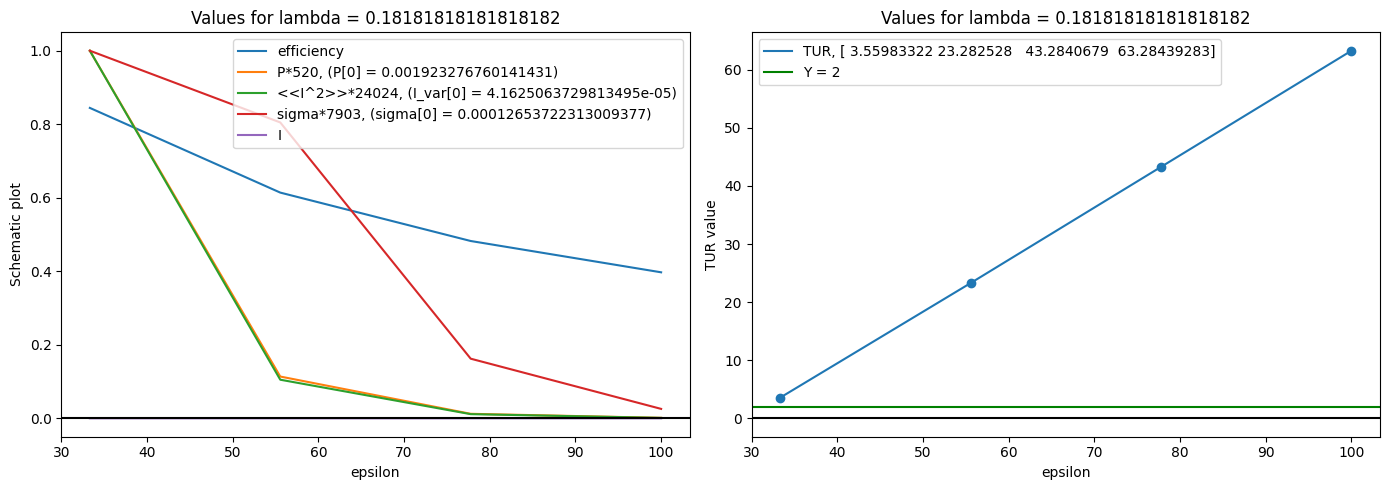

267.8037632728107
267.8037632728107
12208.158091488953
12208.158091488953
4232.444504671405
4232.444504671405


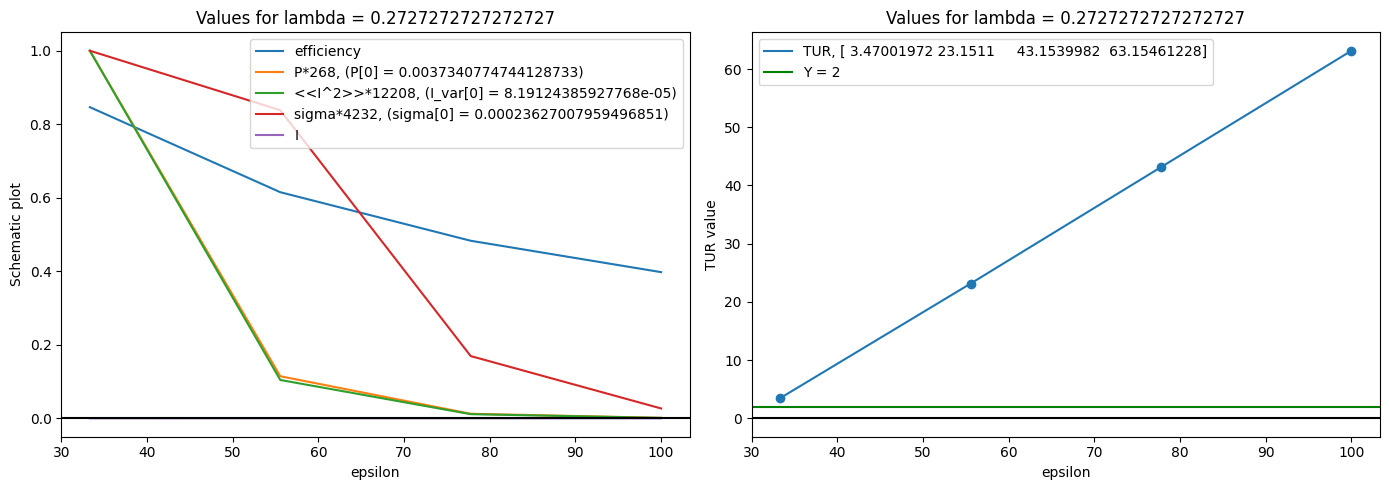

163.33714461580482
163.33714461580482
7387.019046384223
7387.019046384223
2647.0591717298335
2647.0591717298335


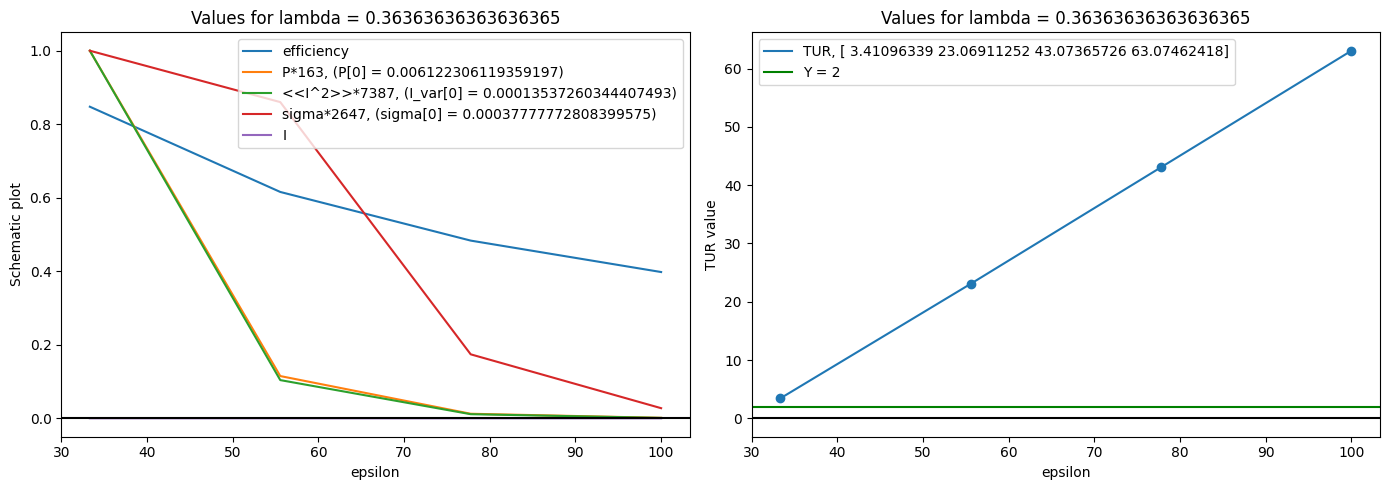

112.24274766866365
112.24274766866365
5052.930873435085
5052.930873435085
1848.2539189406575
1848.2539189406575


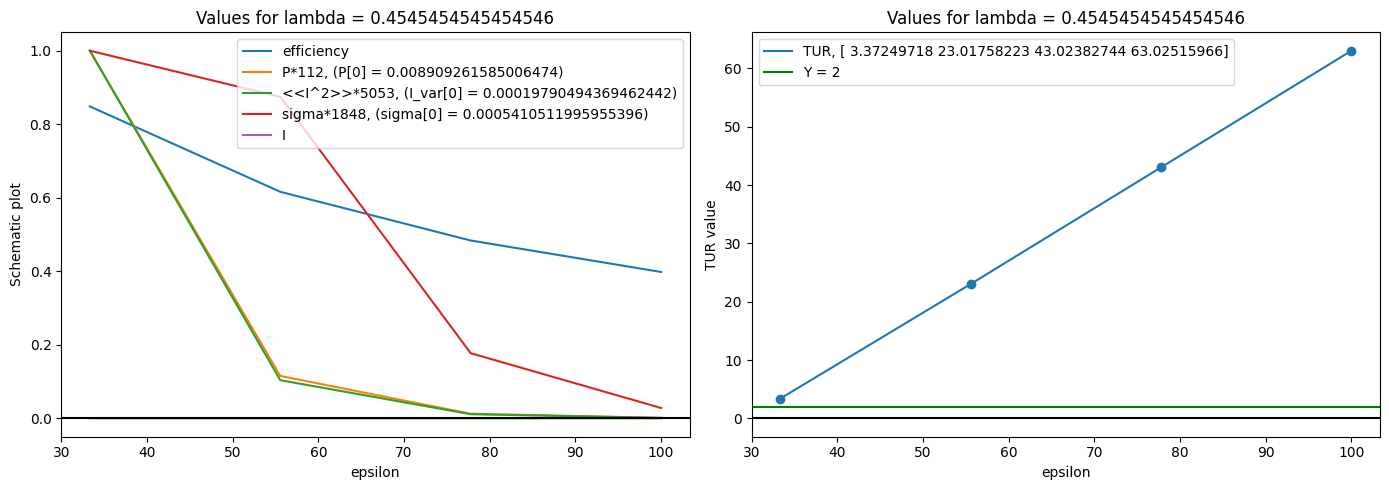

83.929746602757
83.929746602757
3767.94317565391
3767.94317565391
1396.5321273577001
1396.5321273577001


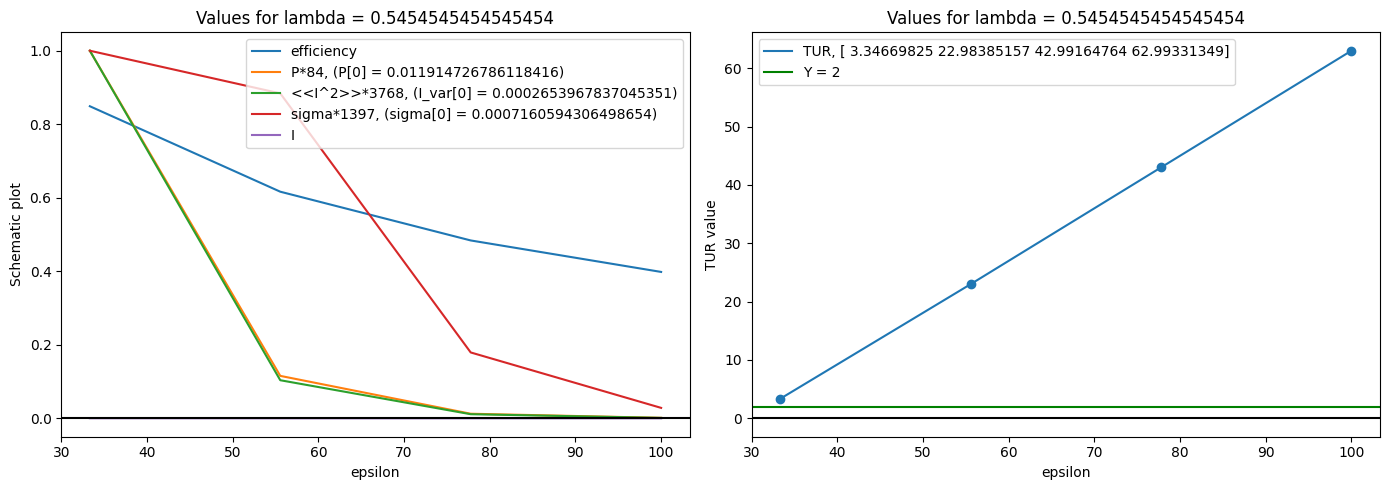

66.74231525952608
66.74231525952608
2991.110989757454
2991.110989757454
1118.440483129666
1118.440483129666


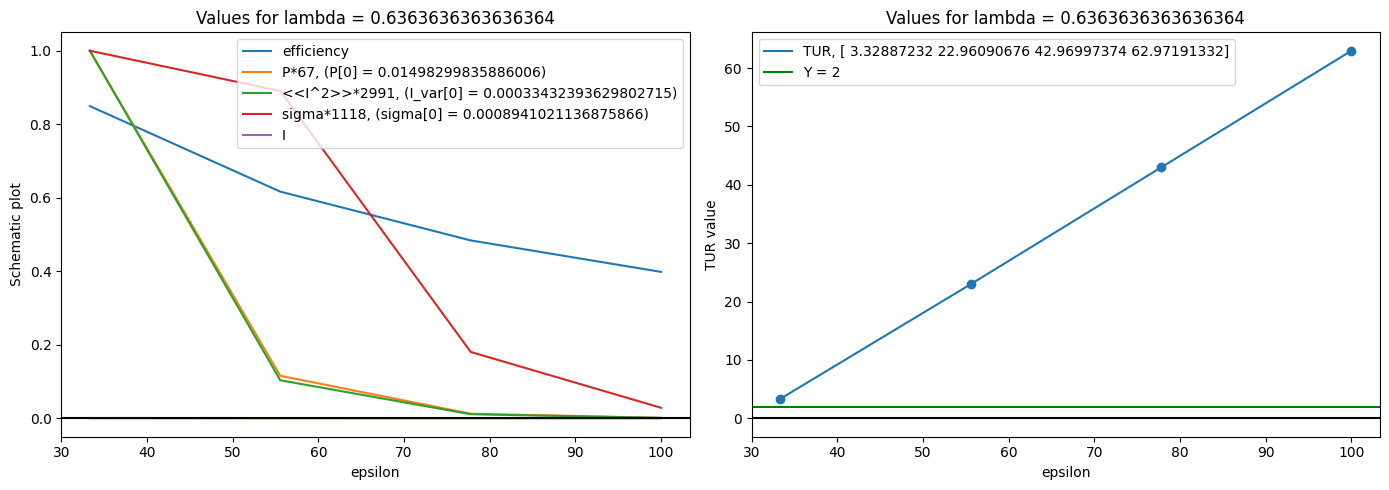

55.56897143869321
55.56897143869321
2487.356462306373
2487.356462306373
935.9127848385737
935.9127848385737


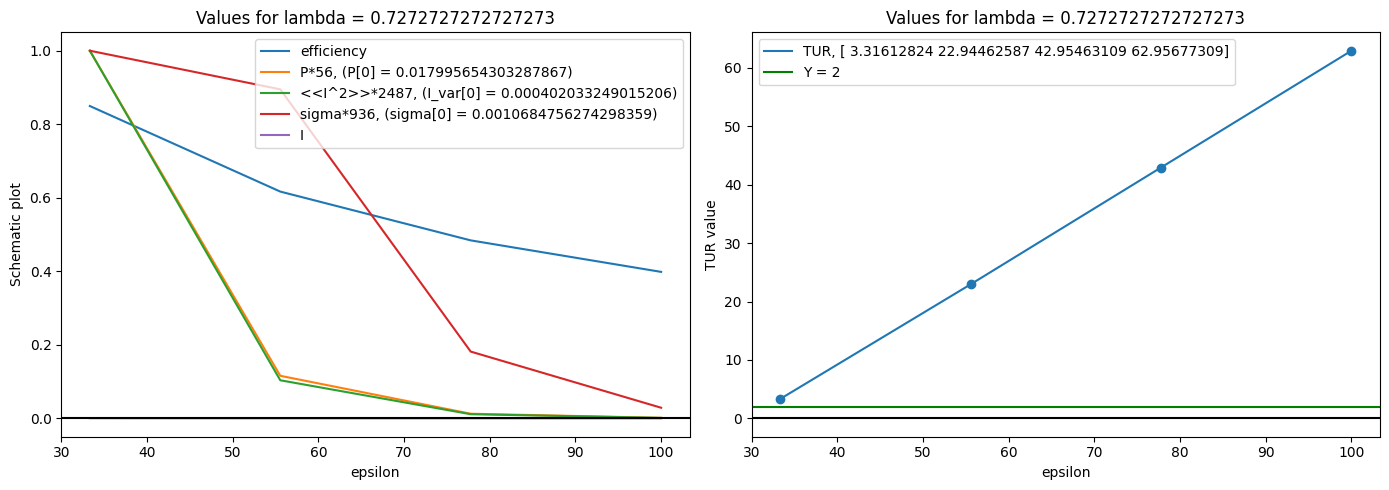

47.90975009807745
47.90975009807745
2142.4622513881336
2142.4622513881336
810.0230297006027
810.0230297006027


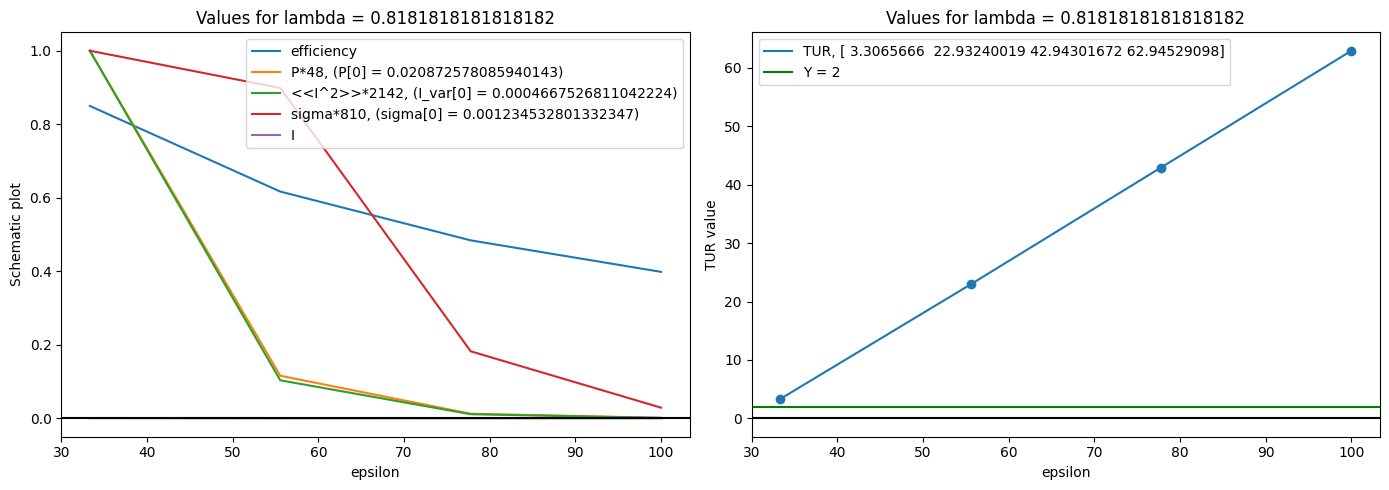

42.433753293736295
42.433753293736295
1895.9202144643994
1895.9202144643994
719.741462341145
719.741462341145


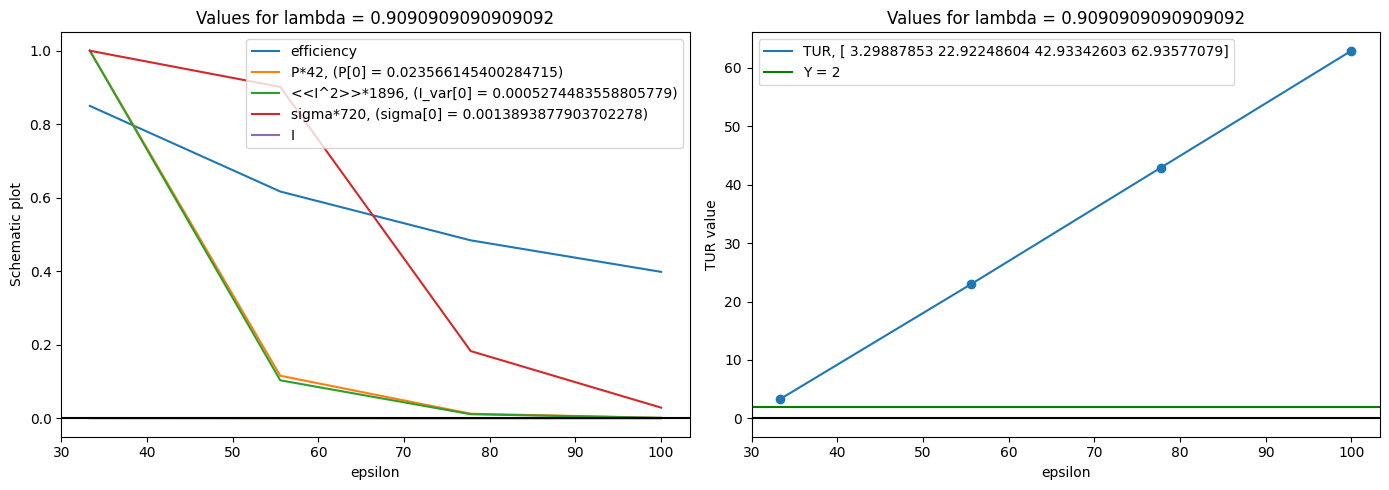

38.3830466137406
38.3830466137406
1713.3985961619755
1713.3985961619755
652.9539821247741
652.9539821247741


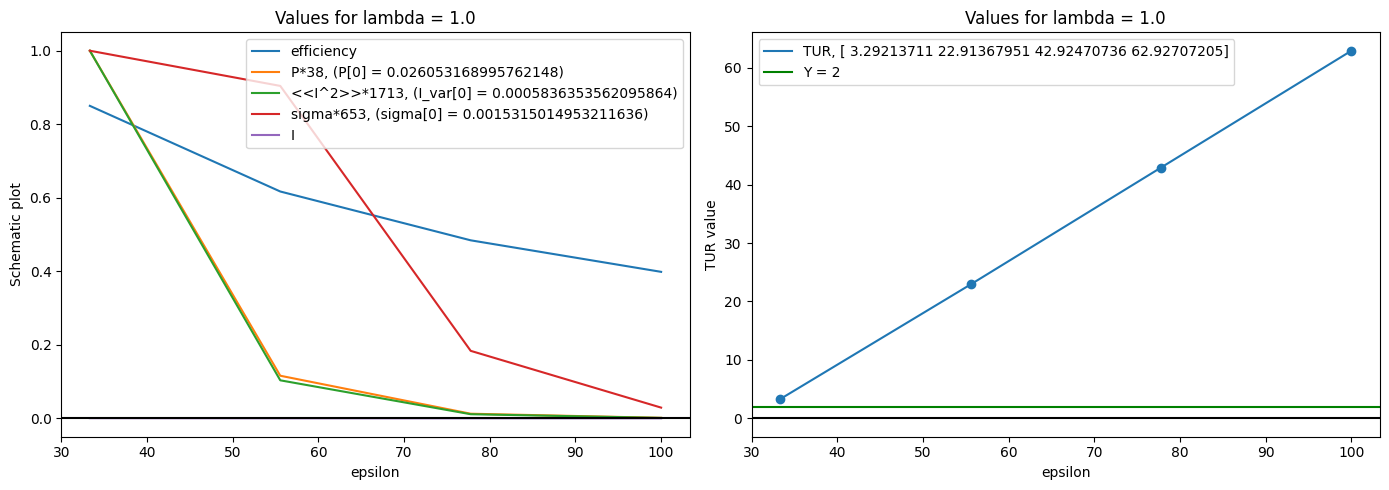

In [21]:
#---------plotting----------------------------------
for idx, lmda in enumerate(lamdas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5)) 

    def get_mult(matrix):
        max = 0
        for e_idx, _ in enumerate(heat_engine_epsilons[idx]):
            if matrix[idx, e_idx] > max:
                max = matrix[idx, e_idx]
        print(1/max)
        return 1/max 


    ax1.plot(heat_engine_epsilons[idx], eff[idx], label='efficiency')
    ax1.plot(heat_engine_epsilons[idx], get_mult(P)*P[idx], label=f'P*{round(get_mult(P))}, (P[0] = {P[idx][0]})')
    ax1.plot(heat_engine_epsilons[idx], get_mult(I_var)*I_var[idx], label=f'<<I^2>>*{round(get_mult(I_var))}, (I_var[0] = {I_var[idx][0]})')
    ax1.plot(heat_engine_epsilons[idx], get_mult(sigma)*sigma[idx], label=f'sigma*{round(get_mult(sigma))}, (sigma[0] = {sigma[idx][0]})')
    ax1.plot(heat_engine_epsilons[idx], I[idx], label='I')
    #ax1.scatter(epsilons, J_QH[idx], label=f'J_QH, 0: {J_QH[idx][0]}, 1: {J_QH[idx][1]}, 2: {J_QH[idx][2]} , 3: {J_QH[idx][3]}, 4: {J_QH[idx][4]}, 5: {J_QH[idx][5]}, 6: {J_QH[idx][6]}')
    ax1.axhline(y=0, color='black', linestyle='-')
    #ax1.set_ylim(-0.01, 0.01)
    ax1.set_xlabel('epsilon')
    ax1.set_ylabel('Schematic plot')
    ax1.set_title(f'Values for lambda = {lmda}')
    ax1.legend()

    ax2.plot(heat_engine_epsilons[idx], TUR[idx], label=f'TUR, {TUR[idx]}')
    ax2.scatter(heat_engine_epsilons[idx], TUR[idx])
    ax2.set_title(f'Values for lambda = {lmda}')
    ax2.axhline(y=2, color='g', linestyle='-', label= 'Y = 2')
    ax2.axhline(y=0, color='black', linestyle='-')
    ax2.set_xlabel('epsilon')
    ax2.set_ylabel('TUR value')
    ax2.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

I: (12, 4)
meshgrid:
epsilon: (12, 4)
lamda: (12, 4)


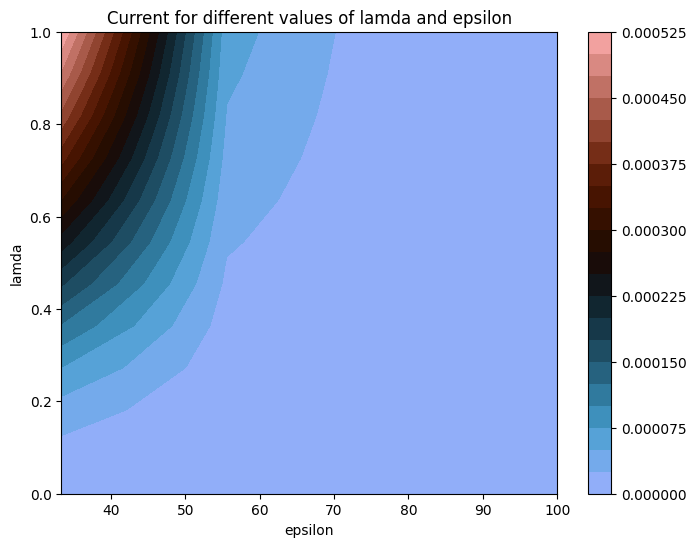

In [7]:
# Plotting of the cummulants

# Create a mesh grid
epsilon, lamda = np.meshgrid(heat_engine_epsilons[0], lamdas)
print('I:',I.shape)
print('meshgrid:')
print('epsilon:', epsilon.shape)
print('lamda:', lamda.shape)

plt.figure(figsize=(8, 6))
# Create a contour plot (or a pcolormesh plot for a smooth color gradient)
contour = plt.contourf(epsilon, lamda, I, 20, cmap='berlin')  # Adjust number of contour levels as needed
#contour = plt.pcolormesh(epsilon, lamda, I, shading='auto', cmap='viridis')
plt.colorbar(contour)
plt.xlabel('epsilon')
plt.ylabel('lamda')
plt.title('Current for different values of lamda and epsilon')
plt.show()

In [8]:
eps = 500
#double QD in series (with spin) ==============================================================================================================
h = {(0,0):eps, (1,1):eps, (2,2):eps, (3,3):eps, (0,2):omega, (1,3):omega} # <-------/// Här skiljer dom sig ! ///----
tleads = {(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR} # <------/// Här skiljer dom sig ! ///----

system_parallell = qmeq.Builder(nsingle=n, hsingle=h, coulomb=U, nleads=nleads,
                         mulst=mulst, tlst=tlst, tleads=tleads, dband=1e4, countingleads=[0,1], kerntype='pyLindblad')
system_parallell.solve()
print('IN SERIES: Standard current:',system_parallell.current)
print('IN SERIES: Counting currents and noise at the left lead (Lindblad):',system_parallell.current_noise)

#double QD in parallel (with spin) ===========================================================================================================
h = {(0,0):eps, (1,1):eps, (2,2):eps, (3,3):eps} # <------/// Här skiljer dom sig ! ///-----
tleads = {(0, 0):tL, (1, 1):tL, (2, 2):tR, (3, 3):tR, (0,2):tL, (1,3):tL, (2,0):tR, (3,1):tR} # <-------/// Här skiljer dom sig ! ///----
#============================================================================================================================================

system_parallell = qmeq.Builder(nsingle=n, hsingle=h, coulomb=U, nleads=nleads,
                         mulst=mulst, tlst=tlst, tleads=tleads, dband=1e4, countingleads=[0,1], kerntype='pyLindblad')
system_parallell.solve()
print('IN PARALLEL: Standard current:',system_parallell.current)
print('IN PARALLEL: Counting currents and noise at the left lead (Lindblad):',system_parallell.current_noise)

IN SERIES: Standard current: [ 6.45327834e-25  6.45327834e-25 -6.45327834e-25 -6.45327834e-25]
IN SERIES: Counting currents and noise at the left lead (Lindblad): [1.29065567e-24 1.29065567e-24]
IN PARALLEL: Standard current: [ 1.58321429e-24  1.58321429e-24 -1.58321429e-24 -1.58321429e-24]
IN PARALLEL: Counting currents and noise at the left lead (Lindblad): [3.16642857e-24 3.16642857e-24]
